In [ ]:
import numpy as np     #import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# update the path where CSV is stored in Drive
data = pd.read_csv('/content/drive/MyDrive/housing.csv')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/housing.csv')


In [ ]:
import os

for root, dirs, files in os.walk("/content/drive/MyDrive"):
    if "housing.csv" in files:
        print("Found at:", os.path.join(root, "housing.csv"))
        break


Found at: /content/drive/MyDrive/housing.csv


In [ ]:
print(data.shape)       # rows, columns
print(data.columns)     # column names
data.head()             # first 5 rows
data.info()             # column types and non-null counts
data.describe()         # basic stats for numeric columns

(20640, 10)
Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [ ]:
data.isnull().sum()    #it counts missing values in each column. If any are non-zero, need to handle them (fill with median)

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,207
population,0
households,0
median_income,0
median_house_value,0
ocean_proximity,0


In [ ]:
#this replaces all NaN values in total_bedrooms with the median of that column
#keeping the dataset consistent without dropping rows
median_value = data['total_bedrooms'].median()
data['total_bedrooms'].fillna(median_value, inplace=True)


/tmp/ipython-input-3476250603.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['total_bedrooms'].fillna(median_value, inplace=True)


In [ ]:
#split dataset into features (X) and target (y)
#Here, the target is median_house_value, and the rest (except ocean_proximity which is categorical) are features

# target column
y = data['median_house_value'].values   #.values->converts column from a pandas Series into a plain NumPy array (so later we can use it in NumPy calculations)


# drop target + categorical column from features
X = data.drop(['median_house_value', 'ocean_proximity'], axis=1).values  #drop removes columns or rows,
                                                                         #axis=1 means “drop along the column axis” (if it were axis=0, it would drop rows)


print("Features shape:", X.shape)
print("Target shape:", y.shape)


Features shape: (20640, 8)
Target shape: (20640,)


The goal of that block of code is to Split your dataset into two parts:

Training set : the model will learn patterns from this data (about 80% of the rows).

Testing set : we keep this hidden until the end, so we can check how well the model performs on unseen data (about 20% of the rows).

In [ ]:
np.random.seed(42)      #locks the random generator to always start at the same point

n = X.shape[0]          #no of rows(no of houses)

indices = np.random.permutation(n)   #creates a shuffled list of row indices

split = int(n*0.8)     #80%train+20%test

train_idx, test_idx = indices[:split], indices[split:] # :split -> everything before split(excluding split)
                                                       # split: -> split pt + everything after

X_train, X_test = X[train_idx], X[test_idx]            #extracts the rows from X and y to create new arrays.
y_train, y_test = y[train_idx], y[test_idx]

print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (16512, 8) (16512,)
Test shapes: (4128, 8) (4128,)


The next step is **normalizing the features**.
Why do we normalize features?

feature columns(X) have very different scales.

If we run gradient descent like this, features with large values will dominate the updates.

Gradient descent will zig-zag and converge very slowly(or not at all).

Normalization fixes this:

We rescale each feature so it has mean = 0 and standard deviation = 1 (z-score normalization).

After this, all features are on the same scale, making training much smoother.

In [ ]:
#The plan is:
#Compute the mean and standard deviation of each feature column from the training set.
#Use those values to rescale both X_train and X_test.
#(Important: we only use training stats, so we don’t “peek” at the test set.)


feat_mean = X_train.mean(axis=0)   # mean of each column
feat_std = X_train.mean(axis=0)    #std of each column

feat_std[feat_std == 0] = 1       #boolean indexing, replaces any value of 0 in array with 1
                                  #to avoid divide by 0 if column has no variation


X_train_norm = (X_train - feat_mean) / feat_std   #normalize training and test sets using training stats
X_test_norm = (X_test - feat_mean) / feat_std



print("Before normalization:", X_train[0])     #first training row before normalization.
print("After normalization :", X_train_norm[0])  #the exact same row after normalization.

Before normalization: [-119.01     36.06     25.     1505.      435.     1392.      359.
    1.6812]
After normalization : [-0.00464287  0.01220786 -0.12763421 -0.42775282 -0.18659159 -0.02102408
 -0.2792497  -0.56563216]


Imagine this

You have a cookie shop.

*   The more sugar you put in → the sweeter the cookie.
*   The more chocolate chips you add → the tastier it gets



But if someone asks:
“How tasty will this cookie be if I add 5 spoons of sugar and 10 chips?”

You want a formula that guesses tastiness from sugar and chips.

We need to find a formula like:

tastiness = (something × sugar) + (something × chips) + starting_point

How do we learn these “somethings”?

We guess them at first, test how close our prediction is to the real tastiness, then adjust:

If we guessed too low → increase the weight.

If we guessed too high → decrease the weight.

We keep adjusting again and again until our line predicts tastiness pretty well.

This “keep adjusting” is called Gradient Descent → just like slowly walking downhill until you reach the lowest point (the smallest error)

In [ ]:
class NumPyLinearRegression:                                               #defined a class
    def __init__(self, lr=0.01, n_iters=1000, verbose=False):              # def->defines a function, self->refers to the object itself, lr->learning rate, n_inters->default training steps, verbose=false->optional flag to print progress
                                                                           # used to set up model settings


        self.lr = lr                          #store the lr of the object
        self.n_iters = n_iters                #store the no of steps
        self.verbose = verbose                #store the flag
        self.w = None                         #weights will be created later
        self.loss_history = []                #empty list to save errors during training




    def _add_bias(self, X):                      #helper function to find bias term(intercept)
        ones = np.ones((X.shape[0], 1))          #make a column of 1 (with no of rows)
        return np.hstack([ones, X])              #np.hstack means “horizontal stack” → put arrays side by side (columns).
                                                 #[ones, X] is a list of arrays we want to stack.
                                                 #So this attaches the column of ones in front of X.



    def fit(self, X, y):                         # fit is a std ML name for "Train the Model", loop to adjust weight until error is small
      Xb = self._add_bias(X)                     # Xb-> same as X but with bias column
      n_samples, n_features = Xb.shape

      self.w = np.zeros((n_features, 1))        #creates a column vector of zeroes for weights, 1 per feature(+bias)
      y = y.reshape(-1, 1)                      #force y to be a column vector, -1 ->figure out the dimension, 1-> make it into a column


      for i in range(self.n_iters):             #run loop n_iters tiems

        pred = Xb.dot(self.w)                   #matrix multiplication ->predicted values

        error = pred - y                        #difference btw predictions and actual

        loss = np.mean(error ** 2) / 2          #compute mean squared error
        self.loss_history.append(loss)          #save it in loss_histroy so we can plot it later

        grad = (2/n_samples) * Xb.T.dot(error)  #slope of error

        self.w = self.w - self.lr * grad        #adjust the weights

        if self.verbose and i % 100 == 0:                    #every 100 steps,print current iteration and lose(if verbose=true)
                print(f"Iteration {i}, Loss: {loss:.4f}")    #f"...." -> f-string: lets u put variables directly inside a string


    def predict(self, X):                     #use trained weights to get new values
        Xb = self._add_bias(X)            #add bias to X
        return Xb.dot(self.w)             #multiplies by weights to get prediction






First guess: completely off.

They tell you “you guessed too low.”

Next time you guess higher.

Keep adjusting until your guesses match reality.

Training = error goes down, weights get better, model learns patterns.

Iteration 0, Loss: 0.5000
Iteration 100, Loss: 0.3995
Iteration 200, Loss: 0.3387
Iteration 300, Loss: 0.3006
Iteration 400, Loss: 0.2763
Iteration 500, Loss: 0.2606
Iteration 600, Loss: 0.2500
Iteration 700, Loss: 0.2428
Iteration 800, Loss: 0.2378
Iteration 900, Loss: 0.2341
Iteration 1000, Loss: 0.2313
Iteration 1100, Loss: 0.2291
Iteration 1200, Loss: 0.2273
Iteration 1300, Loss: 0.2259
Iteration 1400, Loss: 0.2247
Iteration 1500, Loss: 0.2236
Iteration 1600, Loss: 0.2227
Iteration 1700, Loss: 0.2219
Iteration 1800, Loss: 0.2212
Iteration 1900, Loss: 0.2206
Iteration 2000, Loss: 0.2200
Iteration 2100, Loss: 0.2195
Iteration 2200, Loss: 0.2190
Iteration 2300, Loss: 0.2185
Iteration 2400, Loss: 0.2181
Iteration 2500, Loss: 0.2178
Iteration 2600, Loss: 0.2174
Iteration 2700, Loss: 0.2171
Iteration 2800, Loss: 0.2168
Iteration 2900, Loss: 0.2165
Iteration 3000, Loss: 0.2163
Iteration 3100, Loss: 0.2161
Iteration 3200, Loss: 0.2159
Iteration 3300, Loss: 0.2157
Iteration 3400, Loss: 0.21

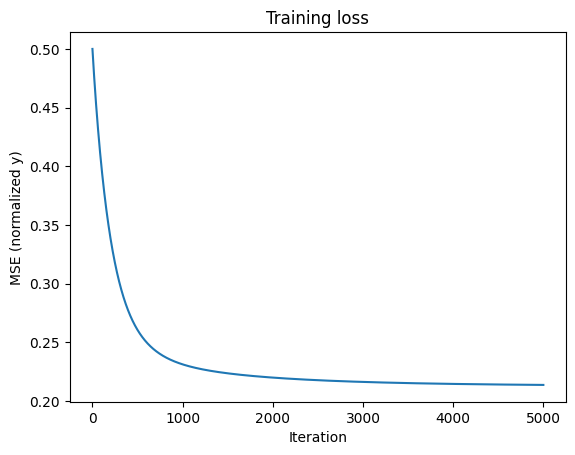

In [ ]:
# Create and train model on normalized data
model = NumPyLinearRegression(lr=0.005, n_iters=5000, verbose=True)
model.fit(X_train_norm, y_train_norm)
# plot loss
plt.plot(model.loss_history)
plt.xlabel("Iteration")
plt.ylabel("MSE (normalized y)")
plt.title("Training loss")
plt.show()


In [ ]:
# Predict (normalized), then rescale to original house values
y_train_pred_norm = model.predict(X_train_norm)   # shape (n,1)
y_test_pred_norm  = model.predict(X_test_norm)
y_train_pred = (y_train_pred_norm * y_std) + y_mean
y_test_pred  = (y_test_pred_norm  * y_std) + y_mean
# flatten for convenience
y_train_pred = y_train_pred.flatten()
y_test_pred  = y_test_pred.flatten()

#Evaluation Metrics for regression models

MSE-> Mean square root error, average of squared errors

RMSE -> Root mean square error, root of MSE

MAE-> Mean absolute error, average mistake value

R^2 -> Coefficient of Determination,

R^2 = 1 : Perfect prediction

......= 0 : no better than predicting mean

......<0 : worse than predicting the mean
  

TRAIN Metrics
MSE : 5699619816.19227
RMSE: 75495.82648194714
MAE : 56002.13107440453
R²  : 0.5707916056636148

TEST Metrics
MSE : 6134454220.736682
RMSE: 78322.75672329646
MAE : 57076.80512770071
R²  : 0.5442413185572631


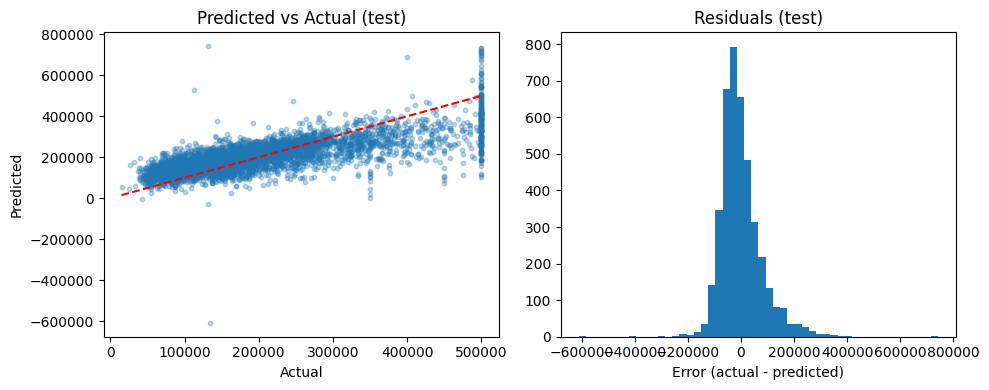

In [ ]:
def mse(y_true, y_pred):
  return np.mean((y_true.flatten() - y_pred.flatten())**2)

def rmse(y_true, y_pred):
  return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
  return np.mean(np.abs(y_true.flatten() - y_pred.flatten()))

def r2_score(y_true, y_pred):
    ss_res = np.sum((y_true.flatten() - y_pred.flatten())**2)
    ss_tot = np.sum((y_true.flatten() - np.mean(y_true))**2)
    return 1 - ss_res/ss_tot


print("TRAIN Metrics")
print("MSE :", mse(y_train, y_train_pred))
print("RMSE:", rmse(y_train, y_train_pred))
print("MAE :", mae(y_train, y_train_pred))
print("R²  :", r2_score(y_train, y_train_pred))

print("\nTEST Metrics")
print("MSE :", mse(y_test, y_test_pred))
print("RMSE:", rmse(y_test, y_test_pred))
print("MAE :", mae(y_test, y_test_pred))
print("R²  :", r2_score(y_test, y_test_pred))

plt.figure(figsize=(10,4))

# scatter actual vs predicted
plt.subplot(1,2,1)
plt.scatter(y_test, y_test_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual (test)")

# residuals histogram
plt.subplot(1,2,2)
residuals = y_test - y_test_pred
plt.hist(residuals, bins=50)
plt.title("Residuals (test)")
plt.xlabel("Error (actual - predicted)")
plt.tight_layout()
plt.show()

